In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Load data

In [6]:
input_data_file = './data.tsv'
df_data = pd.read_csv(input_data_file, sep='\t', usecols=['t', 'x'])
df_data.shape

(200, 2)

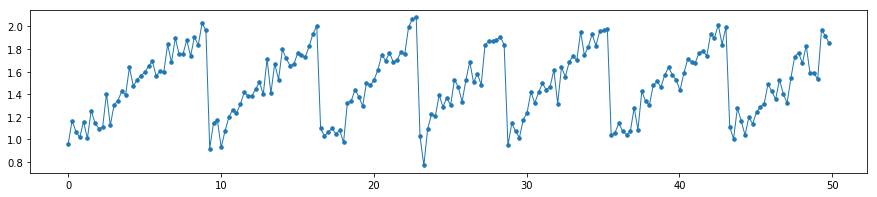

In [165]:
plt.figure(figsize=(15,3))
plt.plot(df_data['t'], df_data['x'], '.-', ms=7, lw=1)
plt.show()

In [113]:
t = np.array(df_data['t'])
x = np.array(df_data['x'])

## Step 2: Detect region boundaries, compile clean data

**2.1** Estimate range assuming uniform distribution

In [19]:
width = np.sqrt(np.var(df_data['x']) * 12)
center = np.mean(df_data['x'])
low = center - width / 2.0
high = center + width / 2.0

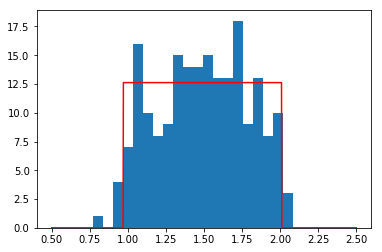

In [20]:
_, bins, _ = plt.hist(df_data['x'], bins=20)
b = bins[1] - bins[0]
N = len(df_data['x'])

x_draw = np.linspace(0.5, 2.5, 1000)
y_draw = np.zeros_like(x_draw)
y_draw[(x_draw >= low) & (x_draw <= high)] = N*b / (high - low)
plt.plot(x_draw, y_draw, 'r-')

plt.show()

**2.2** Estimate period with discrete Fourier transform

In [121]:
def saw_tooth(t, freq, width, y0=0):
    return y0 + width * ( (t * freq) % 1 ) - width / 2.0

0.1405628140703518


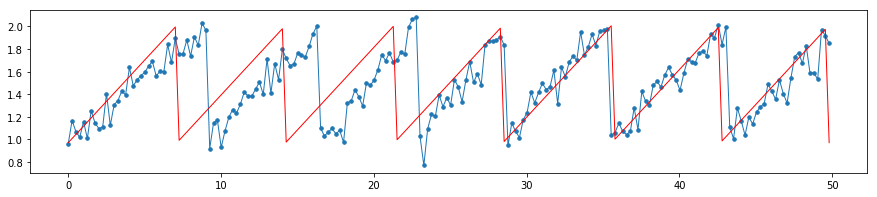

In [162]:
x_fft_power = np.abs(np.fft.rfft(x - np.mean(x)))
main_freq = np.argmax(x_fft_power) / float(t[-1] - t[0])
print(main_freq)

plt.figure(figsize=(15,3))
plt.plot(t, x, '.-', ms=7, lw=1)
plt.plot(t, np.mean(x) + saw_tooth(t, main_freq, width), 'r-', lw=1)
plt.show()

**2.3** Isotonic regression on "straigthened" time series

In [132]:
# from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression

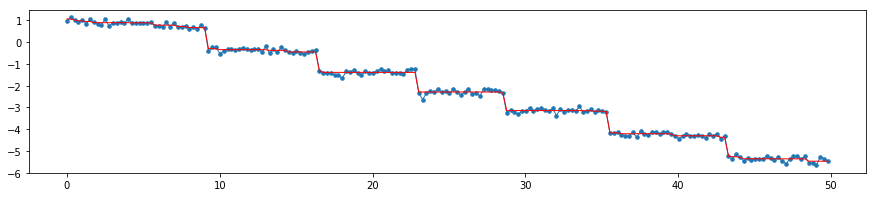

In [161]:
x_drifting = x - main_freq * t * width

iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
x_segmented = iso_reg.predict(t)

plt.figure(figsize=(15,3))
plt.plot(t, x_drifting, '.-', ms=7, lw=1)
plt.plot(t, x_segmented, 'r-', lw=1)
plt.show()

**2.4** Threshold discrete derivative of isotonic regression to find region boundaries

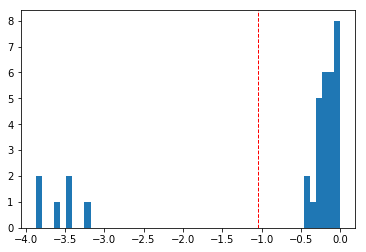

In [177]:
derivative = np.diff(x_segmented) / (t[1] - t[0])

# let's flag any negative change faster than the (negative of) estimated growth rate
estimated_growth_rate = width * freq
plt.hist(derivative[derivative < 0], bins=50)
plt.axvline(- estimated_growth_rate, lw=1, color='r', ls='--')
plt.show()

In [158]:
t_indexes = np.arange(len(t))
t_indexes_after_jump = t_indexes[1:][derivative < - estimated_growth_rate]
t_after_jump = t[t_indexes_after_jump]

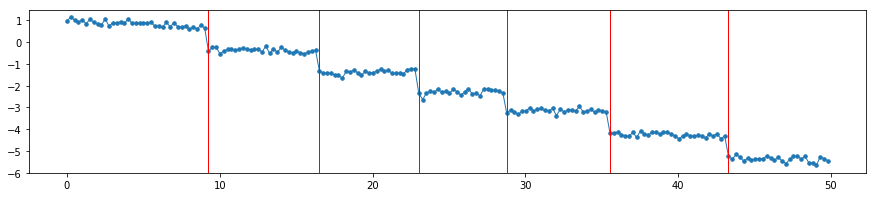

In [163]:
plt.figure(figsize=(15,3))
plt.plot(t, x_drifting, '.-', ms=7, lw=1)
for t_jump in t_after_jump:
    plt.axvline(t_jump, color='r', lw=1)
plt.show()

**2.5** Compile regions

In [168]:
minimum_points_in_region = 5

In [173]:
regions = []
start = 0
potential_region_ends = np.concatenate([t_indexes_after_jump, np.array([len(t)])])
for end in potential_region_ends:
    if end - start >= minimum_points_in_region:
        regions.append(np.arange(start, end, 1))
    start = end

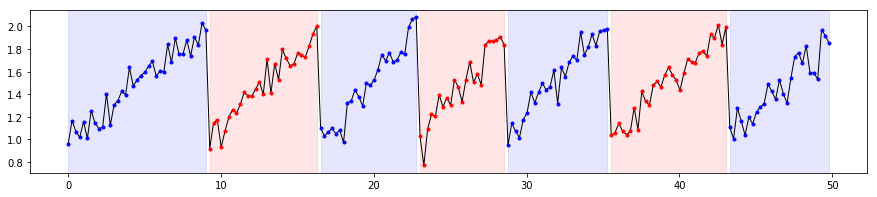

In [190]:
colors = ['blue', 'red']

plt.figure(figsize=(15,3))
plt.plot(df_data['t'], df_data['x'], 'k-', ms=7, lw=1)
for r, region in enumerate(regions):
    color = colors[r % len(colors)]
    plt.plot(t[region], x[region], '.', color=color)
    plt.axvspan(t[region][0], t[region][-1], alpha=0.1, color=color)
plt.show()

**2.6** Compile cleaned data

In [208]:
t_clean = []
x_clean = []
start_idx = []
end_idx = []
for r, region in enumerate(regions):
    tr = list(t[region])
    t_clean += tr
    x_clean += list(x[region])
    start_idx.append(region[0])
    end_idx.append(region[-1])
    
data = {
    'N': len(t_clean),
    'R': len(start_idx),
    't': np.array(t_clean),
    'x': np.array(x_clean),
    's': np.array(start_idx),
    'e': np.array(end_idx)
}

## Step 3: Fit statistical model

In [237]:
from scipy.linalg import block_diag

In [212]:
t = data['t']
x = data['x']
s = data['s']
e = data['e']

**3.1** Calculate $N$, $\gamma$, $Sb$, $SAS^T$

In [338]:
R = len(s)
r = []
for r_idx, (sr, er) in enumerate(zip(s, e)):
    r += [r_idx] * (er - sr + 1)
r = np.array(r)

In [339]:
f = (t[e[r]]*(t - t[s[r]]) - 0.5*(t**2 - t[s[r]]**2)) / (t[e[r]] - t[s[r]])
g = (0.5*(t**2 - t[s[r]]**2) - t[s[r]]*(t - t[s[r]])) / (t[e[r]] - t[s[r]])

In [340]:
gamma_list = []
b_list = []
A_list = []
for r_idx, (sr, er) in enumerate(zip(s, e)):
    ones = np.ones(sum(r==r_idx))
    xr = x[r==r_idx]
    fr = f[r==r_idx]
    gr = g[r==r_idx]
    gamma_list.append(-0.5 * np.sum(xr**2))
    b_list.append(np.array([
        np.sum(xr),
        np.sum(xr * fr),
        np.sum(xr * gr)
    ]))
    A_list.append(np.array([
        [np.sum(ones), np.sum(fr),    np.sum(gr)],
        [np.sum(fr),   np.sum(fr**2), np.sum(fr*gr)],
        [np.sum(gr),   np.sum(fr*gr), np.sum(gr**2)]
    ]))
    
N = x.shape[0]
gamma = np.sum(gamma_list)
b = np.concatenate(b_list)
A = block_diag(*A_list)

In [341]:
S = np.zeros([3*R, 3*R], dtype=int)
for i in range(R):
    j = 3*i
    S[i,j] = 1
for i in range(R, 3*R):
    j = i - R + 1 + (i - R)//2
    S[i,j] = 1

In [342]:
Sb = S.dot(b)
SAST = S.dot(A).dot(S.T)

**3.2** Functions to calculate $\Sigma$ and $m$

In [343]:
lamb = 5

m_x0 = np.ones(R) * np.mean(x)
Sigma_x0 = np.eye(R) * lamb**2 * np.var(x)

In [344]:
T = []
for sr, er in zip(s, e):
    T += [t[sr], t[er]]
T = np.array(T)
    
def m_func(mu_0, nu_0):
    m_mu = mu_0 + nu_0 * T
    return np.concatenate([m_x0, m_mu])

TT = np.concatenate([
    [np.einsum('i,j->ij', T, np.ones_like(T))],
    [np.einsum('i,j->ji', T, np.ones_like(T))],
])

minTT = np.min(TT, axis=0)
maxTT = np.max(TT, axis=0)
Sigma_intBM_profile = 0.5 * minTT**2 * (maxTT - minTT / float(3))
def Sigma_intBM(D):
    return D * Sigma_intBM_profile

dT2 = (TT[0] - TT[1])**2
def Sigma_sqexp(sigma_y, tau):
    return sigma_y**2 * np.exp( - 0.5 * dT2 / tau**2)

def Sigma_func(D, sigma_y, tau):
    Sigma_mu = Sigma_intBM(D) + Sigma_sqexp(sigma_y, tau)
    return block_diag(Sigma_x0, Sigma_mu)

**3.3** Functions for $\mathcal{A}, \mathcal{B}, \mathcal{C}$

In [346]:
def ABC(mu_0, nu_0, D, sigma_mu, tau, sigma_x):
    m = m_func(mu_0, nu_0)
    Sigma = Sigma_func(D, sigma_mu, tau)
    _, logdet_Sigma = np.linalg.slogdet(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)

    AA = SAST / sigma_x**2 + Sigma_inv
    BB = Sb / sigma_x**2 + Sigma_inv.dot(m)
    CC = -0.5*N * np.log(2*np.pi* sigma_x**2 ) \
         -0.5*3*R * np.log(2*np.pi) \
         -0.5 * logdet_Sigma \
         + gamma / sigma_x**2 \
         -0.5 * m.T.dot(Sigma_inv).dot(m)
    
    return AA, BB, CC

**3.4** Function for log likelihood

In [347]:
def LL_func(mu_0, nu_0, D, sigma_mu, tau, sigma_x):
    AA, BB, CC = ABC(mu_0, nu_0, D, sigma_mu, tau, sigma_x)
    return 0.5 * 3*R * np.log(2*np.pi) \
           -0.5 * np.linalg.slogdet(AA)[1] \
           +0.5 * BB.T.dot(np.linalg.inv(AA)).dot(BB) \
           + CC

**3.5** Check prediction formulas for realistic hyperparameter values

In [348]:
mu_0 = 0.1
nu_0 = 0
D = 0.0001
sigma_mu = 0.01
tau = 10
sigma_x = 0.1

AA, BB, CC = ABC(mu_0, nu_0, D, sigma_mu, tau, sigma_x)

In [355]:
AA_inv = np.linalg.inv(AA)
z_ev = AA_inv.dot(BB)
z_cov = AA_inv
z_std = np.sqrt(np.diag(z_cov))

x0_ev = z_ev[:R]
x0_std = z_std[:R]

mu_ev = z_ev[R:]
mu_std = z_std[R:]

In [379]:
def predict_x(r_idx, tr):
    x0 = x0_ev[r_idx]
    mu1, mu2 = mu_ev[2*r_idx:2*r_idx+2]
    ts = t[s[r_idx]]
    te = t[e[r_idx]]
    mu = mu1 * (te - tr) / (te - ts) + mu2 * (tr - ts) / (te - ts)
    dt = np.diff(tr)
    mean_mu = 0.5*(mu[1:] + mu[:-1])
    x = np.cumsum(np.concatenate([[x0], mean_mu * dt]))
    x_low = x - 2 * sigma_x
    x_high = x + 2 * sigma_x
    return x, x_low, x_high

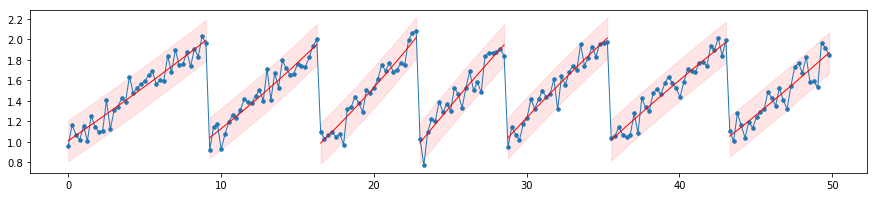

In [380]:
plt.figure(figsize=(15,3))
plt.plot(df_data['t'], df_data['x'], '.-', ms=7, lw=1)
for r_idx in range(R):
    tr = np.linspace(t[s[r_idx]], t[e[r_idx]], 100)
    xr, xr_low, xr_high = predict_x(r_idx, tr)
    plt.plot(tr, xr, 'r-', lw=1)
    plt.fill_between(tr, xr_low, xr_high, color='r', alpha=0.1)

plt.show()

**3.6** Numerically maximize log likelihood

In [383]:
from scipy.optimize import minimize

In [440]:
def func_to_minimize(params):
    mu_0, nu_0, sqrtD, sigma_mu, tau, sigma_x = params
    LL = LL_func(mu_0, nu_0, sqrtD**2, sigma_mu, tau, sigma_x)
    return -LL
    
    
mu_0_init = 0.1
nu_0_init = 1
D_init = 0.1
sigma_mu_init = 1
tau_init = 0.00001
sigma_x_init = 10
params0 = [mu_0_init, 
           nu_0_init, 
           np.sqrt(D_init), 
           sigma_mu_init, 
           tau_init, 
           sigma_x_init]
res = minimize(func_to_minimize, params0)
res.message

'Desired error not necessarily achieved due to precision loss.'

In [441]:
params_opt = {
    'mu_0': res.x[0],
    'nu_0': res.x[1],
    'D': res.x[2]**2,
    'sigma_mu': np.abs(res.x[3]),
    'tau': np.abs(res.x[4]),
    'sigma_x': np.abs(res.x[5])
}

params_opt

{'mu_0': 0.09649797889994222,
 'nu_0': 0.0028082323619600695,
 'D': 8.829202638254841e-07,
 'sigma_mu': 2.712042483630501e-05,
 'tau': 1e-05,
 'sigma_x': 0.09688866599880397}

**3.7** Predict $\mu$ and $x$

In [445]:
def fit_z(params):
    mu_0 = params['mu_0']
    nu_0 = params['nu_0']
    D = params['D']
    sigma_mu = params['sigma_mu']
    tau = params['tau']
    sigma_x = params['sigma_x']
    
    AA, BB, CC = ABC(mu_0, nu_0, D, sigma_mu, tau, sigma_x)
    
    AA_inv = np.linalg.inv(AA)
    z_ev = AA_inv.dot(BB)
    z_cov = AA_inv
    z_std = np.sqrt(np.diag(z_cov))

    x0_ev = z_ev[:R]
    x0_std = z_std[:R]

    mu_ev = z_ev[R:]
    mu_std = z_std[R:]
    
    return {
        'x0_ev': x0_ev,
        'x0_std': x0_std,
        'mu_ev': mu_ev,
        'mu_std': mu_std,
        'z_cov': z_cov
    }

In [453]:
def predict_x(fit):
    x0_ev = fit['x0_ev']
    mu_ev = fit['mu_ev']
    x = []
    x_low = []
    x_high = []
    for r_idx in range(R):
        x0 = x0_ev[r_idx]
        mu1, mu2 = mu_ev[2*r_idx:2*r_idx+2]
        tr = t[s[r_idx]:e[r_idx]+1]
        ts = t[s[r_idx]]
        te = t[e[r_idx]]
        mu = mu1 * (te - tr) / (te - ts) + mu2 * (tr - ts) / (te - ts)
        dt = np.diff(tr)
        mean_mu = 0.5*(mu[1:] + mu[:-1])
        xr = np.cumsum(np.concatenate([[x0], mean_mu * dt]))
        x += list(xr)
        x_low += list(xr - 2 * sigma_x)
        x_high += list(xr + 2 * sigma_x)
    return {
        'x': np.array(x), 
        'x_low': np.array(x_low), 
        'x_high':np.array(x_high)
    }

In [454]:
fit = fit_z(params_opt)
prediction = predict_x(fit)

**3.8** Compare to truth

In [458]:
df_truth = pd.read_csv('./data.tsv', sep='\t', 
                       usecols=['t', 'x_noiseless', 'mu'])

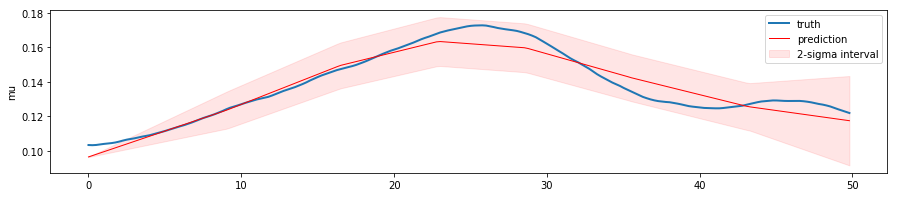

In [468]:
plt.figure(figsize=(15,3))
plt.plot(t, df_truth['mu'], '-', ms=7, lw=2, label='truth')
plt.plot(T, fit['mu_ev'], 'r-', lw=1, label='prediction')
plt.fill_between(T, 
                 fit['mu_ev'] - 2*fit['mu_std'], 
                 fit['mu_ev'] + 2*fit['mu_std'], 
                 color='r', alpha=0.1, label='2-sigma interval')
plt.ylabel('mu')
plt.legend()
plt.show()

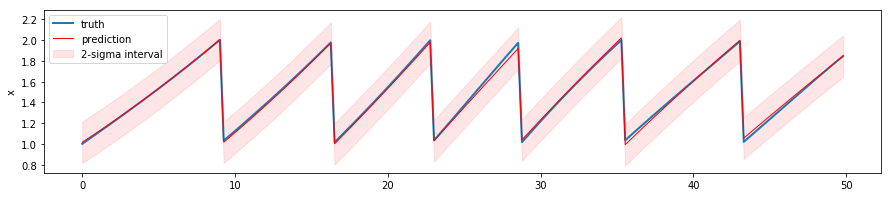

In [463]:
plt.figure(figsize=(15,3))
plt.plot(t, df_truth['x_noiseless'], '-', ms=7, lw=2, label='truth')
plt.plot(t, prediction['x'], 'r-', lw=1, label='prediction')
plt.fill_between(t, prediction['x_low'], prediction['x_high'], 
                 color='r', alpha=0.1, label='2-sigma interval')
plt.ylabel('x')
plt.legend()
plt.show()